In [1]:
import os
import typing
import numpy as np
import ta as ta_lib
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt

pd.options.mode.use_inf_as_na = True

import quantstats as qs
qs.extend_pandas()

# filter warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
source_yahoo: bool = False

### 0. Get Daily OHLCV from YFinance

In [26]:
if source_yahoo:
    symbol = 'CCRO3.SA'

    df_daily = yf.download(symbol, period='2y', interval='1d').reset_index()

    # Drop Adj Close
    df_daily.drop(columns=['Adj Close'], inplace=True)

    # Renaming Datetime column
    df_daily = df_daily.rename(columns={'Datetime': 'Date'})

    display(df_daily.tail())

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Volume
489,2022-04-18,13.47,13.87,13.41,13.65,9868600
490,2022-04-19,13.55,13.82,13.48,13.75,7455500
491,2022-04-20,13.62,14.10,13.61,13.75,7486400
492,2022-04-22,13.57,13.57,13.25,13.34,11407100
493,2022-04-25,13.17,13.35,12.95,13.32,7244500


### 0.2 Get Hourly OHLCV from YFinance

In [75]:
if source_yahoo:
    df_hourly = yf.download(symbol, period='2y', interval='60m').reset_index()

    # Drop Adj Close
    df_hourly.drop(columns=['Adj Close'], inplace=True)

    # Renaming Datetime column
    df_hourly = df_hourly.rename(columns={'Datetime': 'date'})

    # Set date column as index
    df_hourly.set_index('date', inplace=True)

    # Filter hours
    hours = df_hourly.index.hour
    df_hourly = df_hourly.iloc[((hours >= 11) & (hours < 17))]

    df_hourly.index = df_hourly.index.tz_convert(None) - pd.Timedelta(hours=3)

    display(df_hourly.tail(10))

NameError: name 'yf' is not defined

### 0. Get OHLCV hourly from QFLib

In [94]:
if not source_yahoo:

    ticker = 'B3SA3'

    # Get Adjusted 1-min bars
    df = pd.read_parquet(f'../../data/market/ohlcv_minute/{ticker}.parquet')

    # Get close values
    #df = df.close

    # Convert index
    df.index = df.index.tz_convert(None) - pd.Timedelta(hours=3)

    # Filter Trading Hours (10h - 17h)
    hours = df.index.hour
    df = df.iloc[(hours >= 10) & (hours < 17)]

    # Resample 5-min
    df_5min = df.groupby(pd.Grouper(freq='5min')).first().dropna()

    # Resample daily
    df_daily = df.resample('D').last().dropna()
    df_daily.columns = df_daily.columns.droplevel(1)
    df_daily.index = df_daily.index.rename('Date')
    df_daily = df_daily.drop(columns=['qty'])
    df_daily = df_daily.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'})
    df_daily

,Open,High,Low,Close,Volume
Date,,,,,
2018-06-15,5.670173,5.687158,5.633372,5.650357,1.680567e+06
2018-06-18,5.469183,5.472014,5.463522,5.472014,2.148930e+05
2018-06-19,5.630541,5.633372,5.613556,5.633372,1.451839e+05
2018-06-20,5.579586,5.582417,5.559770,5.568263,1.772862e+06
2018-06-21,5.562601,5.573924,5.562601,5.573924,1.420153e+05
...,...,...,...,...,...
2022-04-28,13.570000,13.580000,13.550000,13.550000,7.572100e+05
2022-04-29,13.300000,13.350000,13.300000,13.300000,2.350388e+06
2022-05-02,12.800000,12.800000,12.760000,12.760000,1.277446e+06


### Feature Engineering

In [99]:
def fix_dataset_inconsistencies(dataframe, fill_value=None):
    """TODO"""
    dataframe = dataframe.replace([-np.inf, np.inf], np.nan)

    # This is done to avoid filling middle holes with backfilling.
    if fill_value is None:
        dataframe.iloc[0,:] = dataframe.apply(lambda column: column.iloc[column.first_valid_index()], axis='index')
    else:
        dataframe.iloc[0,:] = dataframe.iloc[0,:].fillna(fill_value)
        
    return dataframe.fillna(axis='index', method='pad').dropna(axis='columns')

def rsi(price: 'pd.Series[pd.Float64Dtype]', period: float) -> 'pd.Series[pd.Float64Dtype]':
    """TODO"""
    r = price.diff()
    upside = np.minimum(r, 0).abs()
    downside = np.maximum(r, 0).abs()
    rs = upside.ewm(alpha=1 / period).mean() / downside.ewm(alpha=1 / period).mean()
    
    return 100 * (1 - (1 + rs) ** -1)

def macd(price: 'pd.Series[pd.Float64Dtype]', fast: float, slow: float, signal: float) -> 'pd.Series[pd.Float64Dtype]':
    """TODO"""
    fm = price.ewm(span=fast, adjust=False).mean()
    sm = price.ewm(span=slow, adjust=False).mean()
    md = fm - sm
    signal = md - md.ewm(span=signal, adjust=False).mean()
    return signal

def generate_all_default_quantstats_features(data):
    """TODO"""
    
    excluded_indicators = [
        'compare',
        'greeks',
        'information_ratio',
        'omega',
        'r2',
        'r_squared',
        'rolling_greeks',
        'warn'
    ]
    
    indicators_list = [f for f in dir(qs.stats) if f[0] != '_' and f not in excluded_indicators]
    
    df = data.copy()
    df = df.set_index('date')
    df.index = pd.DatetimeIndex(df.index)

    for indicator_name in indicators_list:
        try:
            print(indicator_name)
            indicator = qs.stats.__dict__[indicator_name](df['Close'])
            if isinstance(indicator, pd.Series):
                indicator = indicator.to_frame(name=indicator_name)
                df = pd.concat([df, indicator], axis='columns')
        except (pd.errors.InvalidIndexError, ValueError):
            pass

    df = df.reset_index()
    return df

def generate_features(data):
    """TODO"""
    # Automatically-generated using pandas_ta
    df = data.copy()

    strategies = ['candles', 
                  'cycles', 
                  'momentum', 
                  'overlap', 
                  'performance', 
                  'statistics', 
                  'trend', 
                  'volatility', 
                  'volume']

    df.index = pd.DatetimeIndex(df.index)

    cores = os.cpu_count()
    df.ta.cores = cores

#     for strategy in strategies:
#         df.ta.study(strategy)

    # df = df.set_index('Date')

    # Generate all default indicators from ta library
    ta_lib.add_all_ta_features(data, 
                            'Open', 
                            'High', 
                            'Low', 
                            'Close', 
                            'Volume', 
                            fillna=True)
    
    # data = data.set_index('Date')

    # Custom indicators
    features = pd.DataFrame.from_dict({
        'prev_open': data['Open'].shift(1),
        'prev_high': data['High'].shift(1),
        'prev_low': data['Low'].shift(1),
        'prev_close': data['Close'].shift(1),
        'prev_volume': data['Volume'].shift(1),
        'vol_5': data['Close'].rolling(window=5).std().abs(),
        'vol_10': data['Close'].rolling(window=10).std().abs(),
        'vol_20': data['Close'].rolling(window=20).std().abs(),
        'vol_30': data['Close'].rolling(window=30).std().abs(),
        'vol_50': data['Close'].rolling(window=50).std().abs(),
        'vol_60': data['Close'].rolling(window=60).std().abs(),
        'vol_100': data['Close'].rolling(window=100).std().abs(),
        'vol_200': data['Close'].rolling(window=200).std().abs(),
        'ma_5': data['Close'].rolling(window=5).mean(),
        'ma_10': data['Close'].rolling(window=10).mean(),
        'ma_20': data['Close'].rolling(window=20).mean(),
        'ma_30': data['Close'].rolling(window=30).mean(),
        'ma_50': data['Close'].rolling(window=50).mean(),
        'ma_60': data['Close'].rolling(window=60).mean(),
        'ma_100': data['Close'].rolling(window=100).mean(),
        'ma_200': data['Close'].rolling(window=200).mean(),
        'ema_5': ta_lib.trend.ema_indicator(data['Close'], window=5, fillna=True),
        'ema_10': ta_lib.trend.ema_indicator(data['Close'], window=10, fillna=True),
        'ema_20': ta_lib.trend.ema_indicator(data['Close'], window=20, fillna=True),
        'ema_60': ta_lib.trend.ema_indicator(data['Close'], window=60, fillna=True),
        'ema_64': ta_lib.trend.ema_indicator(data['Close'], window=64, fillna=True),
        'ema_120': ta_lib.trend.ema_indicator(data['Close'], window=120, fillna=True),
        'lr_open': np.log(data['Open']).diff().fillna(0),
        'lr_high': np.log(data['High']).diff().fillna(0),
        'lr_low': np.log(data['Low']).diff().fillna(0),
        'lr_close': np.log(data['Close']).diff().fillna(0),
        'r_volume': data['Close'].diff().fillna(0),
        'rsi_5': rsi(data['Close'], period=5),
        'rsi_10': rsi(data['Close'], period=10),
        'rsi_100': rsi(data['Close'], period=100),
        'rsi_7': rsi(data['Close'], period=7),
        'rsi_28': rsi(data['Close'], period=28),
        'rsi_6': rsi(data['Close'], period=6),
        'rsi_14': rsi(data['Close'], period=14),
        'rsi_26': rsi(data['Close'], period=24),
        'macd_normal': macd(data['Close'], fast=12, slow=26, signal=9),
        'macd_short': macd(data['Close'], fast=10, slow=50, signal=5),
        'macd_long': macd(data['Close'], fast=200, slow=100, signal=50)
    })

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, features], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    # Revert naming convention
    data = data.rename(columns={'Open': 'open', 
                                'High': 'high', 
                                'Low': 'low', 
                                'Close': 'close', 
                                'Volume': 'volume'})

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, df], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    data = data.reset_index()
    
    # Revert naming convention
    data = data.rename(columns={'Date': 'date'})

    # Generate all default quantstats features
    df_quantstats = generate_all_default_quantstats_features(data)

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, df_quantstats], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    # A lot of indicators generate NaNs at the beginning of DataFrames, so remove them
    data = data.iloc[200:]
    data = data.reset_index(drop=True)

    data = fix_dataset_inconsistencies(data, fill_value=None)
    
    data.set_index('date', inplace=True)
    
    return data

In [100]:
data_daily = generate_features(df_daily)

adjusted_sortino
autocorr_penalty
avg_loss
avg_return
avg_win
best
cagr
calmar
common_sense_ratio
comp
compsum
conditional_value_at_risk
consecutive_losses
consecutive_wins
cpc_index
cvar
distribution
drawdown_details
expected_return
expected_shortfall
exposure
gain_to_pain_ratio
geometric_mean
ghpr
implied_volatility
kelly_criterion
kurtosis
max_drawdown
monthly_returns
outlier_loss_ratio
outlier_win_ratio
outliers
payoff_ratio
pct_rank
profit_factor
profit_ratio
rar
recovery_factor
remove_outliers
risk_of_ruin
risk_return_ratio
rolling_sharpe
rolling_sortino
rolling_volatility
ror
serenity_index
sharpe
skew
smart_sharpe
smart_sortino
sortino
tail_ratio
to_drawdown_series
ulcer_index
ulcer_performance_index
upi
value_at_risk
var
volatility
win_loss_ratio
win_rate
worst


In [122]:
for col in data_daily.columns:
    print (col)

open
high
low
close
volume
volume_adi
volume_obv
volume_cmf
volume_fi
volume_em
volume_sma_em
volume_vpt
volume_vwap
volume_mfi
volume_nvi
volatility_bbm
volatility_bbh
volatility_bbl
volatility_bbw
volatility_bbp
volatility_bbhi
volatility_bbli
volatility_kcc
volatility_kch
volatility_kcl
volatility_kcw
volatility_kcp
volatility_kchi
volatility_kcli
volatility_dcl
volatility_dch
volatility_dcm
volatility_dcw
volatility_dcp
volatility_atr
volatility_ui
trend_macd
trend_macd_signal
trend_macd_diff
trend_sma_fast
trend_sma_slow
trend_ema_fast
trend_ema_slow
trend_vortex_ind_pos
trend_vortex_ind_neg
trend_vortex_ind_diff
trend_trix
trend_mass_index
trend_dpo
trend_kst
trend_kst_sig
trend_kst_diff
trend_ichimoku_conv
trend_ichimoku_base
trend_ichimoku_a
trend_ichimoku_b
trend_stc
trend_adx
trend_adx_pos
trend_adx_neg
trend_cci
trend_visual_ichimoku_a
trend_visual_ichimoku_b
trend_aroon_up
trend_aroon_down
trend_aroon_ind
trend_psar_up
trend_psar_down
trend_psar_up_indicator
trend_psar_down

In [104]:
# 2020 - Now
data_daily = data_daily.loc['2020':]
data_daily

,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,Volume,compsum,implied_volatility,outliers,pct_rank,remove_outliers,rolling_sharpe,rolling_sortino,rolling_volatility,to_drawdown_series
date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,13.302497,13.305468,13.281698,13.281698,1.308114e+06,7.538397e+07,9.455459e+06,0.415924,45811.662575,1.114919,...,1.308114e+06,1.352416e+307,0.336490,18.732437,20.000000,13.281698,1.245112,1.804289,0.327310,-0.094666
2020-01-03,13.008338,13.011310,13.005367,13.005367,4.604488e+05,7.492352e+07,8.995010e+06,0.407723,21090.551982,-0.368139,...,4.604488e+05,1.352416e+307,0.337204,18.732437,10.000000,13.005367,1.200084,1.735190,0.328113,-0.113502
2020-01-06,12.889487,12.898400,12.886515,12.892458,6.614909e+05,7.492352e+07,8.333519e+06,0.407811,7407.834425,-0.208206,...,6.614909e+05,1.352416e+307,0.336985,18.732437,6.666667,12.892458,1.027735,1.480477,0.327373,-0.121198
2020-01-07,13.269813,13.278726,13.266841,13.272784,8.957926e+05,7.492352e+07,9.229312e+06,0.392767,55020.032816,0.504609,...,8.957926e+05,1.352416e+307,0.336288,18.732437,15.000000,13.272784,1.003145,1.441379,0.326540,-0.095274
2020-01-08,13.284669,13.290612,13.281698,13.287640,3.866133e+05,7.505239e+07,9.615925e+06,0.389707,47980.558773,0.030828,...,3.866133e+05,1.352416e+307,0.335892,18.732437,20.000000,13.287640,0.888575,1.272346,0.325412,-0.094261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-28,13.570000,13.580000,13.550000,13.550000,7.572100e+05,1.427807e+08,-1.774584e+08,-0.253746,-227114.766703,0.178286,...,7.572100e+05,1.352416e+307,0.382762,18.592902,13.333333,13.550000,0.720386,1.105356,0.373813,-0.331500
2022-04-29,13.300000,13.350000,13.300000,13.300000,2.350388e+06,1.404303e+08,-1.798088e+08,-0.297701,-278612.228602,-0.510554,...,2.350388e+06,1.352416e+307,0.382872,18.592902,8.333333,13.300000,0.490805,0.747797,0.373310,-0.343834
2022-05-02,12.800000,12.800000,12.760000,12.760000,1.277446e+06,1.391528e+08,-1.810862e+08,-0.310993,-337356.315945,-1.706530,...,1.277446e+06,1.352416e+307,0.385005,18.592902,1.666667,12.760000,0.591818,0.916898,0.368557,-0.370476


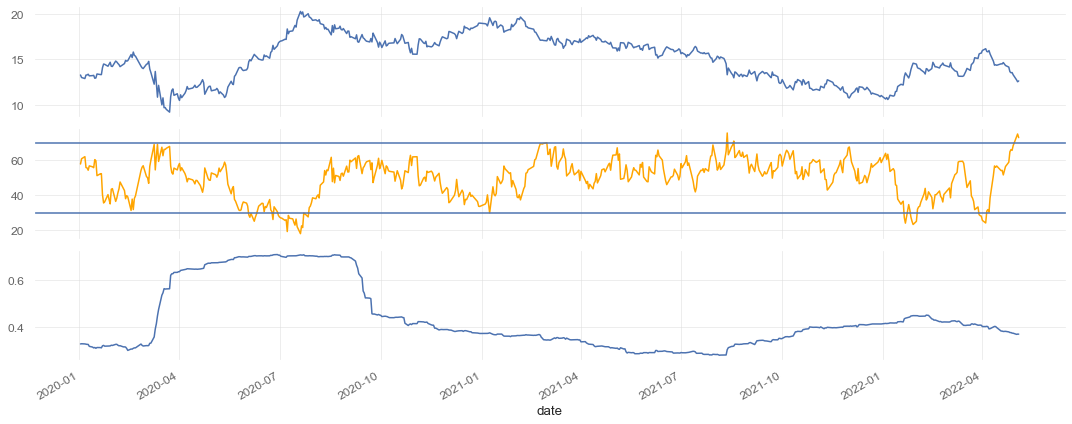

In [125]:
fig, ax = plt.subplots(3, sharex=True, figsize=(15,6))
data_daily.close.plot(ax=ax[0])

data_daily.rsi_14.plot(ax=ax[1], color='orange')
ax[1].axhline(30)
ax[1].axhline(70)

data_daily['rolling_volatility'].plot(ax=ax[2])


plt.tight_layout();

In [43]:
data_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 294 entries, 2021-02-18 to 2022-04-25
Columns: 148 entries, open to to_drawdown_series
dtypes: float64(145), int64(3)
memory usage: 342.2 KB


In [ ]:
aaa

In [44]:
data_daily.shape

(294, 148)

In [49]:
# Renaming columns
df_hourly = df_hourly.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'})

In [ ]:
# Daily OHLCV with Technical Indicators
data_daily_hourly = data_daily.resample('H').pad()

# Merge Daily info into Hourly Prices
# TODO: Merge do 'data_daily_hourly' em 'df_hourly'
data_daily_hourly = df_hourly.merge(data_daily_hourly, left_index=True, right_index=True, how='inner')

# Filter 
hour = data_daily_hourly.index.hour
data_daily_hourly = data_daily_hourly.iloc[((hour >= 11) & (hour < 17))]

In [ ]:
data_daily_hourly

---

In [ ]:
fig, ax = plt.subplots(figsize=(20,6))
data_daily_hourly.loc['2021':].close.plot(ax=ax)
ax.set_title(f'{symbol[:5]} Closing Prices')
ax.set_ylabel('Price (R$)')
ax.set_xlabel('Date')
plt.legend()
plt.tight_layout();